# Performance on simulated protons and muons

In [1]:
%load_ext autoreload
%autoreload 2

import math
from itertools import product
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic

import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from calo_likelihood import caloLikelihood
from helpers import *
from loaders import *

In [2]:
today = '19_10_29'

In [3]:
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon/
!mkdir -p ~/Dropbox/MicroBooNE/_fig/$today/proton_muon/pdfs/

In [4]:
save_folder = '/home/nic/Dropbox/MicroBooNE/_fig/' + today + '/proton_muon/'
save_folder_pdfs = save_folder + 'pdfs/'

In [5]:
branches = [
#     'run',
#     'su',
#     'evt',
    
#     'slpdg',
#     'nslice',
    
    'backtracked_pdg',
    'backtracked_e',
    'backtracked_purity',
    'backtracked_completeness',
    'backtracked_overlay_purity',
#     'backtracked_px',
#     'backtracked_py',
#     'backtracked_pz',
#     'backtracked_start_x',
#     'backtracked_start_y',
#     'backtracked_start_z',
#     'backtracked_start_t',
#     'backtracked_start_U',
#     'backtracked_start_V',
#     'backtracked_start_Y',
#     'backtracked_sce_start_x',
#     'backtracked_sce_start_y',
#     'backtracked_sce_start_z',
#     'backtracked_sce_start_U',
#     'backtracked_sce_start_V',
#     'backtracked_sce_start_Y',

#     'true_nu_vtx_x',
#     'true_nu_vtx_y',
#     'true_nu_vtx_z', 
#     'true_nu_vtx_sce_x',
#     'true_nu_vtx_sce_y',
#     'true_nu_vtx_sce_z',
    
#     'reco_nu_vtx_x',
#     'reco_nu_vtx_y',
#     'reco_nu_vtx_z', 
#     'reco_nu_vtx_sce_x',
#     'reco_nu_vtx_sce_y',
#     'reco_nu_vtx_sce_z',
    
    'nplanehits_U',
    'nplanehits_V',
    'nplanehits_Y',
    'trk_score',

    'trk_start_x',
    'trk_start_y',
    'trk_start_z',

    'trk_end_x',
    'trk_end_y',
    'trk_end_z',
    
    'trk_theta',
    'trk_phi',

    'trk_dir_x',
    'trk_dir_y',
    'trk_dir_z',
    
    'trk_pid_chipr',
    'trk_pid_chipr_u',
    'trk_pid_chipr_v',
    'trk_pid_chimu',
    'trk_bragg_p',
    'trk_bragg_mu',

    'trk_len',
    
#     'dqdx_u',
#     'dqdx_v',
#     'dqdx_y',

    'dedx_u',
    'dedx_v',
    'dedx_y',

    'rr_u',
    'rr_v',
    'rr_y',

    'pitch_u',
    'pitch_v',
    'pitch_y',
    
#     'x_u',
#     'x_v',
#     'x_y',
    
#     'y_u',
#     'y_v',
#     'y_y',
    
#     'z_u',
#     'z_v',
#     'z_y',
    
#     'dir_x_u',
#     'dir_x_v',
#     'dir_x_y',
    
#     'dir_y_u',
#     'dir_y_v',
#     'dir_y_y',
    
#     'dir_z_u',
#     'dir_z_v',
#     'dir_z_y',
]

In [6]:
# file_bnb = '~/Desktop/MicroBooNE/bnb_nue_analysis/v15/bnb_nu_cc0pinp/out.root'

# folder = "nuselection"
# tree = "CalorimetryAnalyzer"

# split_factor = 0.5
# root_file = uproot.open(file_bnb)[folder][tree]
# entry_split = int(len(root_file) * split_factor)
# array_train = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
# array_test = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split)

In [7]:
file_bnb = '~/Desktop/MicroBooNE/bnb_nue_analysis/v15/bnb_nu_cc0pinp/out.root'

folder = "nuselection"
tree = "CalorimetryAnalyzer"

split_factor = 0.05
split_factor2 = 0.1
root_file = uproot.open(file_bnb)[folder][tree]
entry_split = int(len(root_file) * split_factor)
entry_split2 = int(len(root_file) * split_factor2)
array_train = root_file.arrays(branches, namedecode="utf-8", entrystop=entry_split)
array_test = root_file.arrays(branches, namedecode="utf-8", entrystart=entry_split, entrystop=entry_split2)

In [8]:
for array in [array_train, array_test]:
    abs_pitch(array)
    clip_rr(array)
    vertex_is_fiducial(array, name_in='trk_start', name_out='start_is_fiducial')
    vertex_is_fiducial(array, name_in='trk_end', name_out='end_is_fiducial')

In [9]:
def selection_for_train(array):
    return (array['backtracked_completeness'] > 0.9) &\
           (array['backtracked_purity'] > 0.9) &\
           (array['start_is_fiducial']) &\
           (array['end_is_fiducial']) &\
           ((abs(array['backtracked_pdg']) == 13) | (abs(array['backtracked_pdg']) == 2212))

In [10]:
selection_train = selection_for_train(array_train)
selection_test = selection_for_train(array_test)

muon_train = (abs(array_train['backtracked_pdg']) == 13)
proton_train = (abs(array_train['backtracked_pdg']) == 2212)

muon_test = (abs(array_test['backtracked_pdg']) == 13)
proton_test = (abs(array_test['backtracked_pdg']) == 2212)

In [11]:
parameters_names = ['rr', 'abs_pitch']
parameters_bin_edges = [[0., 2, 4, 7, 10, 15, 20, 30, 50, 100, 150, 200, 2000, np.inf],
                  [.0, 0.6, 1, 1.5, 3, 30, np.inf]]

dedx_var = 'dedx'
dedx_bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 12, 15, 20, 30, 50, np.inf]

parameters = []
dedx_vars = []
for plane in ['u', 'v', 'y']:
    parameters.append([parameter_name+'_'+plane for parameter_name in parameters_names])
    dedx_vars.append(dedx_var+'_'+plane)

pdgcode_var = 'backtracked_pdg'

In [12]:
caloLike_train = caloLikelihood(array_train, quality_mask=selection_train)
caloLike_test = caloLikelihood(array_test, quality_mask=selection_test)

caloLike_train.setPdgCodeVar(pdgcode_var)
caloLike_test.setPdgCodeVar(pdgcode_var)

In [13]:
array = caloLike_test.array
for i in [0, 1, 2]:
    caloLike_train.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_train.buildLookUpTableMC(i, 13)    
    caloLike_train.buildLookUpTableMC(i, 2212)    
    caloLike_train.buildLookUpLogLikelihoodRatio(i, [13, 2212])
    caloLike_test.setVariablesBinning(i, parameters[i], parameters_bin_edges, dedx_vars[i], dedx_bins)
    caloLike_test.lookup_tables = caloLike_train.lookup_tables    
    
    array['like_13_{}'.format(i)] = caloLike_train.likelihoodWholeDataset(array=array, 
                                      plane_num=i, 
                                      pdg_code=13)
    array['like_2212_{}'.format(i)] = caloLike_train.likelihoodWholeDataset(array=array, 
                                      plane_num=i, 
                                      pdg_code=2212)
    array['like_13_sum_{}'.format(i)] = array['like_13_{}'.format(i)].sum()
    array['like_2212_sum_{}'.format(i)] = array['like_2212_{}'.format(i)].sum()
    array['log_like_ratio_{}'.format(i)] = array['like_13_sum_{}'.format(i)] - array['like_2212_sum_{}'.format(i)]
    
array['log_like_ratio'] = array['log_like_ratio_0'] + array['log_like_ratio_1'] + array['log_like_ratio_2']
array['log_like_ratio_01'] = array['log_like_ratio_0'] + array['log_like_ratio_1']

/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/calo_likelihood.py:156: RuntimeWarning: invalid value encountered in true_divide
  hist_total/hist_partial[..., np.newaxis],
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/calo_likelihood.py:167: RuntimeWarning: divide by zero encountered in log
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/calo_likelihood.py:167: RuntimeWarning: invalid value encountered in subtract
  np.log(table_1) - np.log(table_2),
/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/calo_likelihood.py:272: RuntimeWarning: divide by zero encountered in log
  return np.log(self.lookup_tables[pdg_code][plane_num][lookup_index])
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/home/nic/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value en

In [33]:
caloLike_train.printCplusplusCode(filename='/home/nic/Dropbox/MicroBooNE/bnb_nue_analysis/calorimetry_likelihood/larsoft_dev/outlookup.h', planes=[0, 1, 2])

In [2]:
caloLike_train.logLikelihoodRatioOneHit(2, 2.5, [15, 1])

NameError: name 'caloLike_train' is not defined

## Plot of the pdfs/likelihoods in bins of residual range and pitch

### Plot PDFs from lookup tables

In [24]:
for plane_num in [0, 1, 2]:
    bin_centers = product(*caloLike_train.parameters_bin_centers[plane_num])
    for bin_center in bin_centers:
        caloLike_train.plotLookUpDedxMC(plane_num=plane_num, 
                                  pdg_code=13, 
                                  parameters_value=bin_center, 
                                  label='muon')
        caloLike_train.plotLookUpDedxMCfancy(plane_num=plane_num, 
                                  pdg_code=2212, 
                                  parameters_value=bin_center, 
                                  label='proton')
        plt.xlim(0, 20)
        plt.savefig(save_folder_pdfs+'plane_{}_rr_{}_pitch_{}.png'.format(plane_num, bin_center[0], bin_center[1]), dpi=250)
        plt.close()

## Plots

In [16]:
def add_norm_variable(array, var, scale=100):
    array[var+'_n'] = 2/math.pi*np.arctan(array[var]/scale)

In [17]:
add_norm_variable(caloLike_test.array, 'trk_pid_chipr')
add_norm_variable(caloLike_test.array, 'log_like_ratio_0')
add_norm_variable(caloLike_test.array, 'log_like_ratio_1')
add_norm_variable(caloLike_test.array, 'log_like_ratio_2')

In [129]:
def selection_for_test(array):
    return selection_for_train(array) &\
              ~np.isnan(array['log_like_ratio_0']) &\
              ~np.isnan(array['log_like_ratio_1']) &\
              ~np.isnan(array['log_like_ratio_2']) &\
              ~np.isinf(array['log_like_ratio_0']) &\
              ~np.isinf(array['log_like_ratio_1']) &\
              ~np.isinf(array['log_like_ratio_2'])

def muon_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==13)

def proton_for_test(array):
    return selection_for_test(array) & (np.abs(array['backtracked_pdg'])==2212)

In [1]:
var = 'trk_pid_chipr'
bins = 41
range = [0, 300]
caloLike_test.plotVariableMC(var, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', alpha=0.5);
caloLike_test.plotVariableMCFancy(var, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', alpha=0.5);
plt.xlabel('$\chi^2_{proton}$')
plt.tight_layout()
# plt.savefig(save_folder + 'chi2_proton_muon.png', dpi=250)

NameError: name 'caloLike_test' is not defined

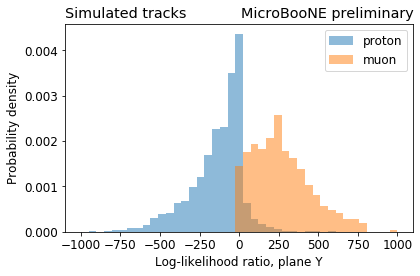

In [141]:
var = 'log_like_ratio_2'
bins = 41
range = [-1000, 1000]
caloLike_test.plotVariableMC(var, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', alpha=0.5);
caloLike_test.plotVariableMCFancy(var, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', alpha=0.5);
plt.xlabel('Log-likelihood ratio, plane Y')
plt.tight_layout()
plt.savefig(save_folder + 'LLR_y_proton_muon.png', dpi=250)

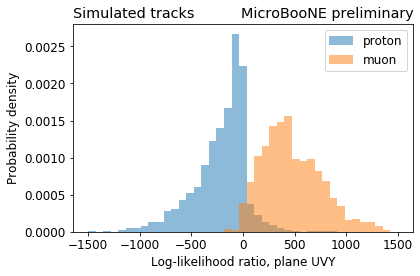

In [142]:
var = 'log_like_ratio'
bins = 41
range = [-1500, 1500]
caloLike_test.plotVariableMC(var, bins, range, function_mask=proton_for_test, quality_mask=True, label='proton', alpha=0.5);
caloLike_test.plotVariableMCFancy(var, bins, range, function_mask=muon_for_test, quality_mask=True, label='muon', alpha=0.5);
plt.xlabel('Log-likelihood ratio, plane UVY')
plt.tight_layout()
plt.savefig(save_folder + 'LLR_uvy_proton_muon.png', dpi=250)

## ROC curves

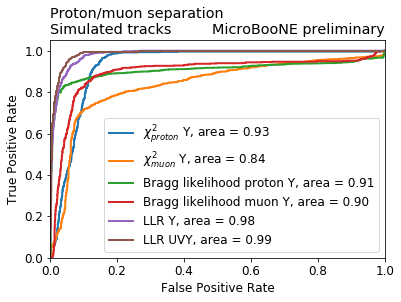

In [134]:
selection = selection_for_test

caloLike_test.rocCurve(variable='trk_pid_chipr', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='$\chi^2_{proton}$ Y')

caloLike_test.rocCurve(variable='trk_pid_chimu', 
     pdg_codes=[2212, 13], 
     selection_function=selection, 
     plot=True,
     variable_label='$\chi^2_{muon}$ Y')

caloLike_test.rocCurve(variable='trk_bragg_p', 
     pdg_codes=[2212, 13], 
     selection_function=selection, 
     plot=True,
     variable_label='Bragg likelihood proton Y')

caloLike_test.rocCurve(variable='trk_bragg_mu', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='Bragg likelihood muon Y')

caloLike_test.rocCurve(variable='log_like_ratio_2', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='LLR Y')

caloLike_test.rocCurve(variable='log_like_ratio', 
     pdg_codes=[13, 2212], 
     selection_function=selection, 
     plot=True,
     variable_label='LLR UVY')

plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.savefig(save_folder + 'roc_curves.png', dpi=250)

(0.8, 1)

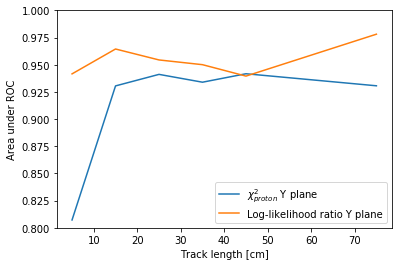

In [102]:
def selection(array, bin_range):
    return selection_for_train(array) &\
              ~np.isnan(array['log_like_ratio']) &\
              ~np.isinf(array['log_like_ratio']) &\
           (array['trk_len'] >= bin_range[0]) &\
           (array['trk_len'] < bin_range[1])

track_len_binning = [0, 10, 20, 30, 40, 50, 100]
roc_chi2 = []
roc_like_u = []
bin_centers = []
for binning in zip(track_len_binning[:-1], track_len_binning[1:]):
    bin_centers.append((binning[0] + binning[1])/2)
    
    roc_chi2.append(caloLike_test.rocCurve(variable='trk_pid_chipr', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='$\chi^2_{proton}$ y plane',
         bin_range=binning))

    roc_like_u.append(caloLike_test.rocCurve(variable='log_like_ratio_2', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio Y plane',
         bin_range=binning))
    
plt.plot(bin_centers, roc_chi2,
         label='$\chi^2_{proton}$ Y plane')
plt.plot(bin_centers, roc_like_u,
         label='Log-likelihood ratio Y plane')
plt.legend()
plt.xlabel('Track length [cm]')
plt.ylabel('Area under ROC')
plt.ylim(0.8, 1)
plt.savefig(save_folder + 'roc_curves.png', dpi=250)

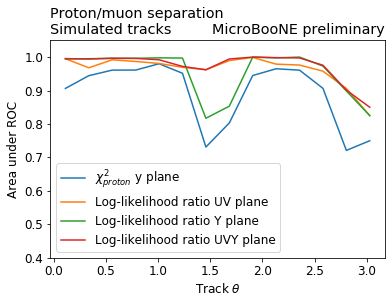

In [135]:
def selection(array, bin_range):
    return selection_for_test(array) &\
           (array['trk_theta'] >= bin_range[0]) &\
           (array['trk_theta'] < bin_range[1])

track_len_binning = np.linspace(0, math.pi, 15)
roc_chi2 = []
roc_like_uv = []
roc_like_y = []
roc_like_uvy = []
bin_centers = []
for binning in zip(track_len_binning[:-1], track_len_binning[1:]):
    bin_centers.append((binning[0] + binning[1])/2)
    
    roc_chi2.append(caloLike_test.rocCurve(variable='trk_pid_chipr', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='$\chi^2_{proton}$ y plane',
         bin_range=binning))

    roc_like_uv.append(caloLike_test.rocCurve(variable='log_like_ratio_01', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UV plane',
         bin_range=binning))
    
    roc_like_y.append(caloLike_test.rocCurve(variable='log_like_ratio_2', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio Y plane',
         bin_range=binning))
    
    roc_like_uvy.append(caloLike_test.rocCurve(variable='log_like_ratio', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UVY plane',
         bin_range=binning))
    
plt.plot(bin_centers, roc_chi2,
         label='$\chi^2_{proton}$ y plane')
plt.plot(bin_centers, roc_like_uv,
         label='Log-likelihood ratio UV plane')
plt.plot(bin_centers, roc_like_y,
         label='Log-likelihood ratio Y plane')
plt.plot(bin_centers, roc_like_uvy,
         label='Log-likelihood ratio UVY plane')
plt.legend()
plt.xlabel(r'Track $\theta$')
plt.ylabel('Area under ROC')
plt.ylim(0.4, 1.05)
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.savefig(save_folder + 'roc_curve_theta.png', dpi=250)

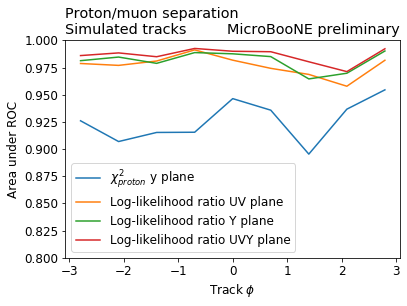

In [136]:
def selection(array, bin_range):
    return selection_for_test(array) &\
           (array['trk_phi'] >= bin_range[0]) &\
           (array['trk_phi'] < bin_range[1])

track_len_binning = np.linspace(-math.pi, math.pi, 10)
roc_chi2 = []
roc_like_uv = []
roc_like_y = []
roc_like_uvy = []
bin_centers = []
for binning in zip(track_len_binning[:-1], track_len_binning[1:]):
    bin_centers.append((binning[0] + binning[1])/2)
    
    roc_chi2.append(caloLike_test.rocCurve(variable='trk_pid_chipr', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='$\chi^2_{proton}$ y plane',
         bin_range=binning))

    roc_like_uv.append(caloLike_test.rocCurve(variable='log_like_ratio_01', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UV plane',
         bin_range=binning))
    
    roc_like_y.append(caloLike_test.rocCurve(variable='log_like_ratio_2', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio Y plane',
         bin_range=binning))
    
    roc_like_uvy.append(caloLike_test.rocCurve(variable='log_like_ratio', 
         pdg_codes=[13, 2212], 
         selection_function=selection,
         variable_label='Log-likelihood ratio UVY plane',
         bin_range=binning))
    
plt.plot(bin_centers, roc_chi2,
         label='$\chi^2_{proton}$ y plane')
plt.plot(bin_centers, roc_like_uv,
         label='Log-likelihood ratio UV plane')
plt.plot(bin_centers, roc_like_y,
         label='Log-likelihood ratio Y plane')
plt.plot(bin_centers, roc_like_uvy,
         label='Log-likelihood ratio UVY plane')
plt.legend()
plt.xlabel(r'Track $\phi$')
plt.ylabel('Area under ROC')
plt.title('Proton/muon separation\nSimulated tracks', loc='left')
plt.title('MicroBooNE preliminary', loc='right')
plt.ylim(0.8, 1)
plt.savefig(save_folder + 'roc_curve_phi.png', dpi=250)